In [319]:
import numpy as np
from scipy.stats.distributions import gamma, expon, burr, logistic, loggamma, lognorm
from scipy.stats.kde import gaussian_kde
from scipy.stats import kstest, cramervonmises, shapiro
from scipy.optimize import curve_fit
from scipy import signal
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


style.use("seaborn-white")
plt.rc("figure", figsize=(20, 20))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../london_merged.csv", parse_dates=["timestamp"], index_col="timestamp")
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [106]:
chosen_vars = [
    df.cnt.apply(lambda x: np.log(x+1)).diff(1).dropna(),
    df.t1.diff(1).dropna(),
    df.hum.diff(1).dropna(),
    df.wind_speed.diff(1).dropna()
]
targets = chosen_vars[:2]

In [104]:
def plot_series(series, ax=plt):
    result = smt.stattools.adfuller(series)
    ax.plot(series, label=series.name)
    ax.plot(series.rolling(24*5).mean(), label='mean')
    ax.plot(series.rolling(24*5).var(), label='variance')
    ax.legend()
    ax.title.set_text(f"Augmented Dickey-Fuller test p-value for {series.name}: {result[1]}")

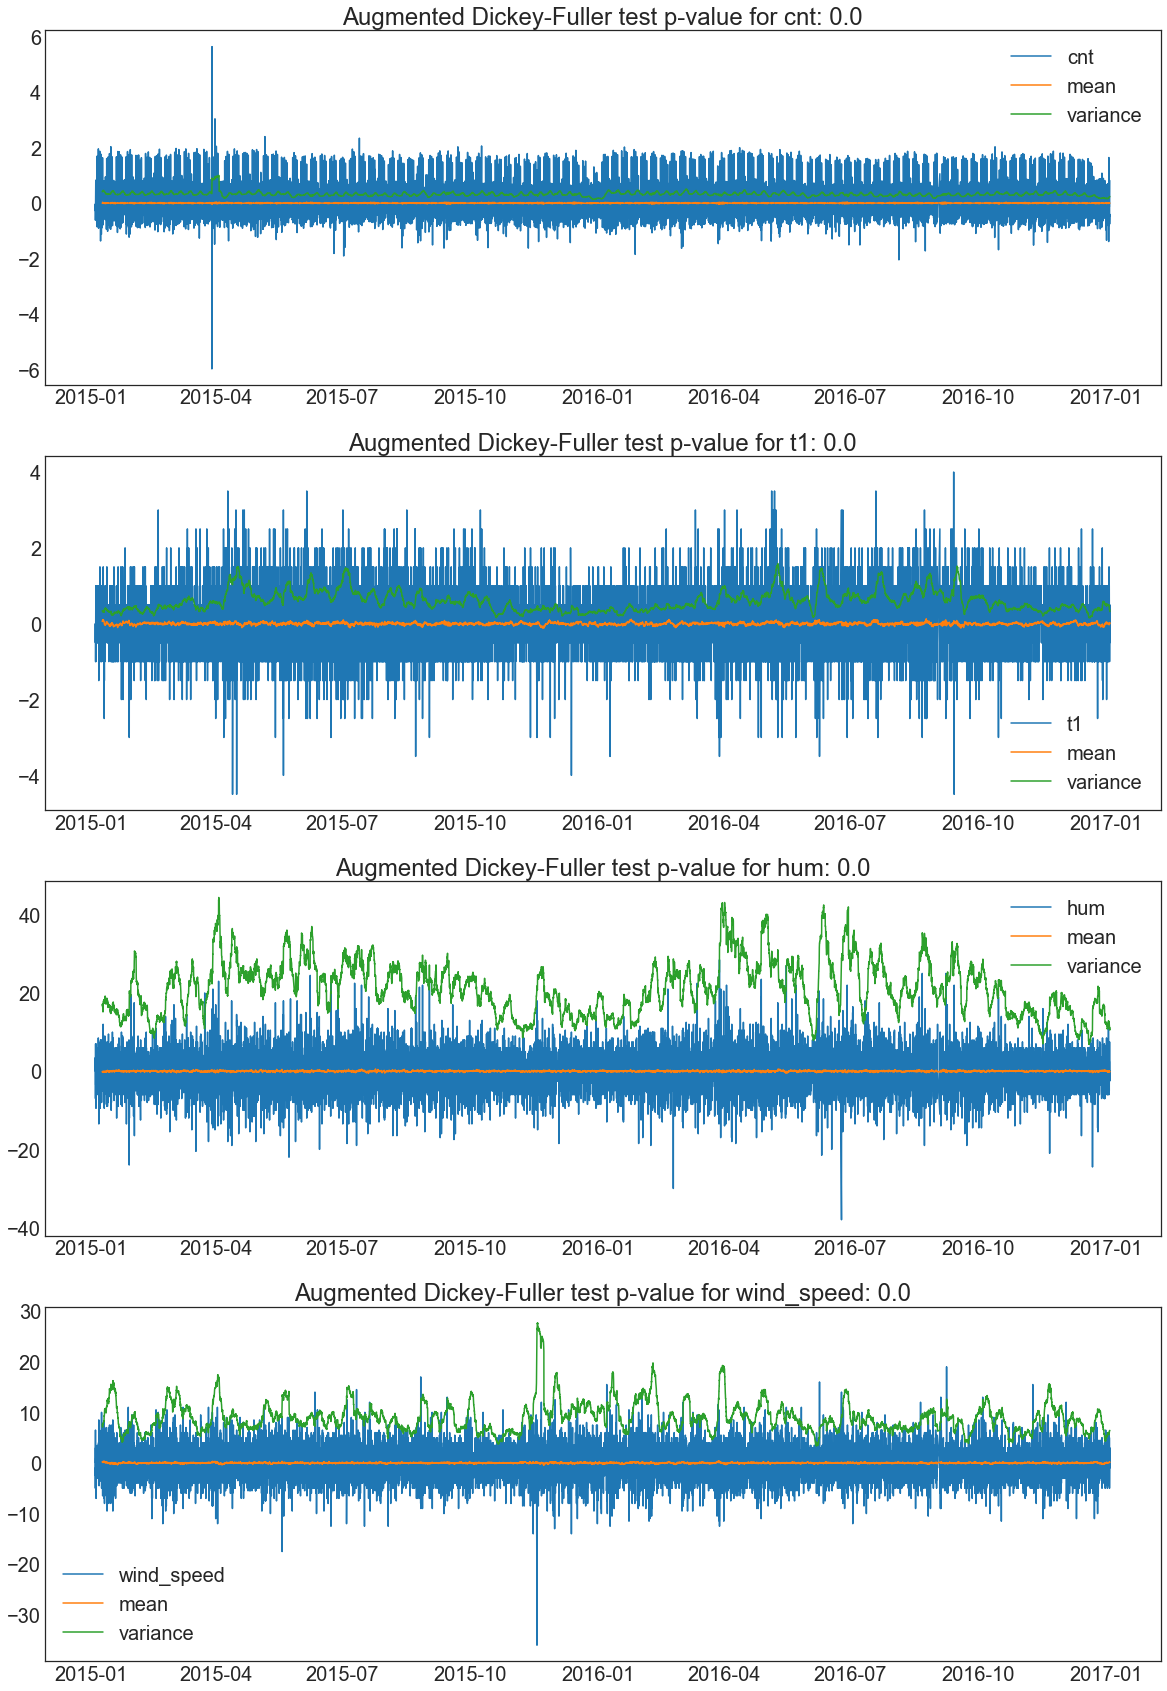

In [105]:
_, axes = plt.subplots(nrows=len(chosen_vars), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_series(chosen_vars[i], ax=ax)

In [126]:
def plot_acovf(series, ax1, ax2, nlag=100):
    ax1.plot(smt.stattools.acovf(series), label=series.name)
    ax2.plot(smt.stattools.acovf(series, nlag=nlag), label=series.name)
    for x in range(24, nlag, 24):
        ax2.axvline(x, c='r', alpha=0.3)
    ax1.legend()
    ax2.legend()

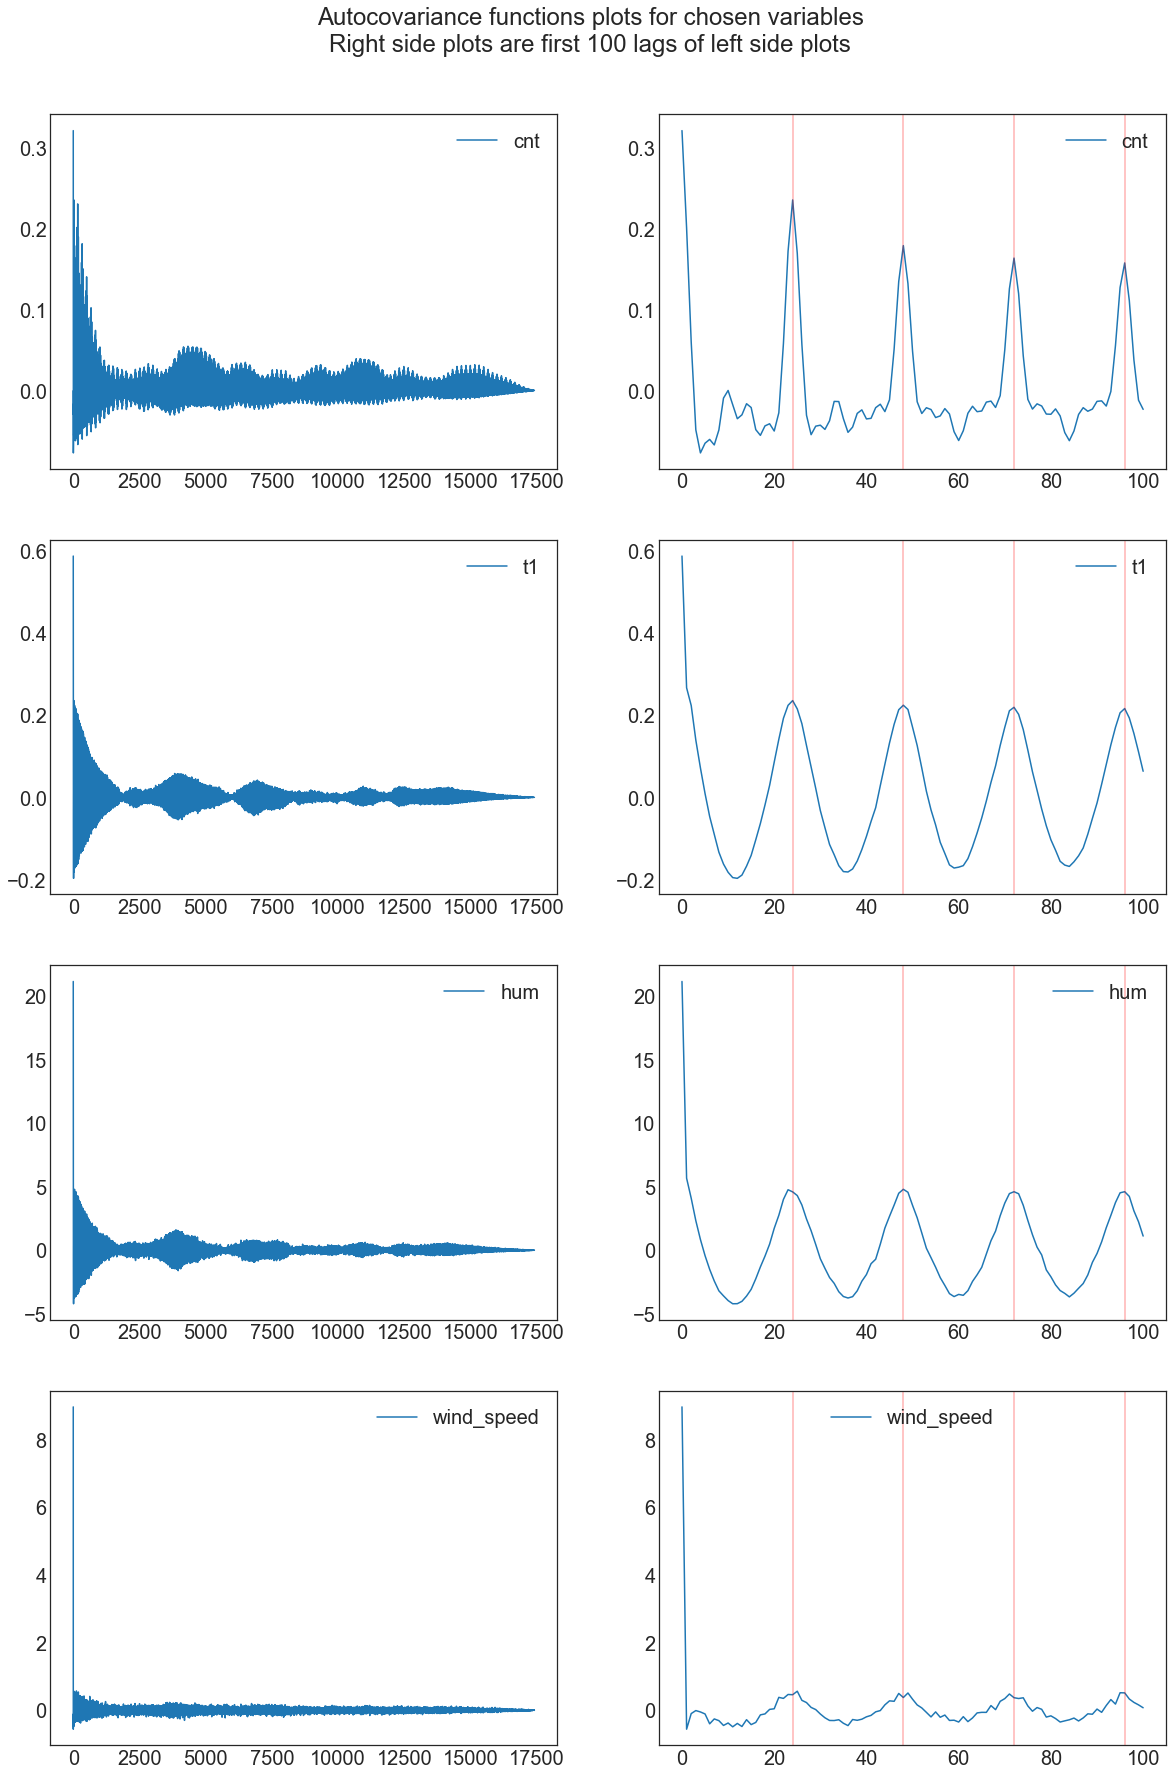

In [128]:
nlag = 100
_, axes = plt.subplots(nrows=len(chosen_vars), ncols=2, figsize=(20, 30))
plt.suptitle("Autocovariance functions plots for chosen variables\n"
             f"Right side plots are first {nlag} lags of left side plots", y=0.93)
for i, ax_row in enumerate(axes):
    plot_acovf(chosen_vars[i], ax1=ax_row[0], ax2=ax_row[1], nlag=nlag)

Analysis of the plots shows that all chosen variables have 24-hour seasonality.

In [167]:
def plot_target_filtered(series, ax):
    ax.plot(series, label='True series')
    ax.plot(filter1(series), label='First filtered series')
    ax.plot(filter2(series), label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

In [234]:
filter1 = lambda x: x.rolling(window=24, win_type='gaussian', center=True).mean(std=1)
filter2 = lambda x: x.rolling(window=12, win_type='hamming', center=True).mean()

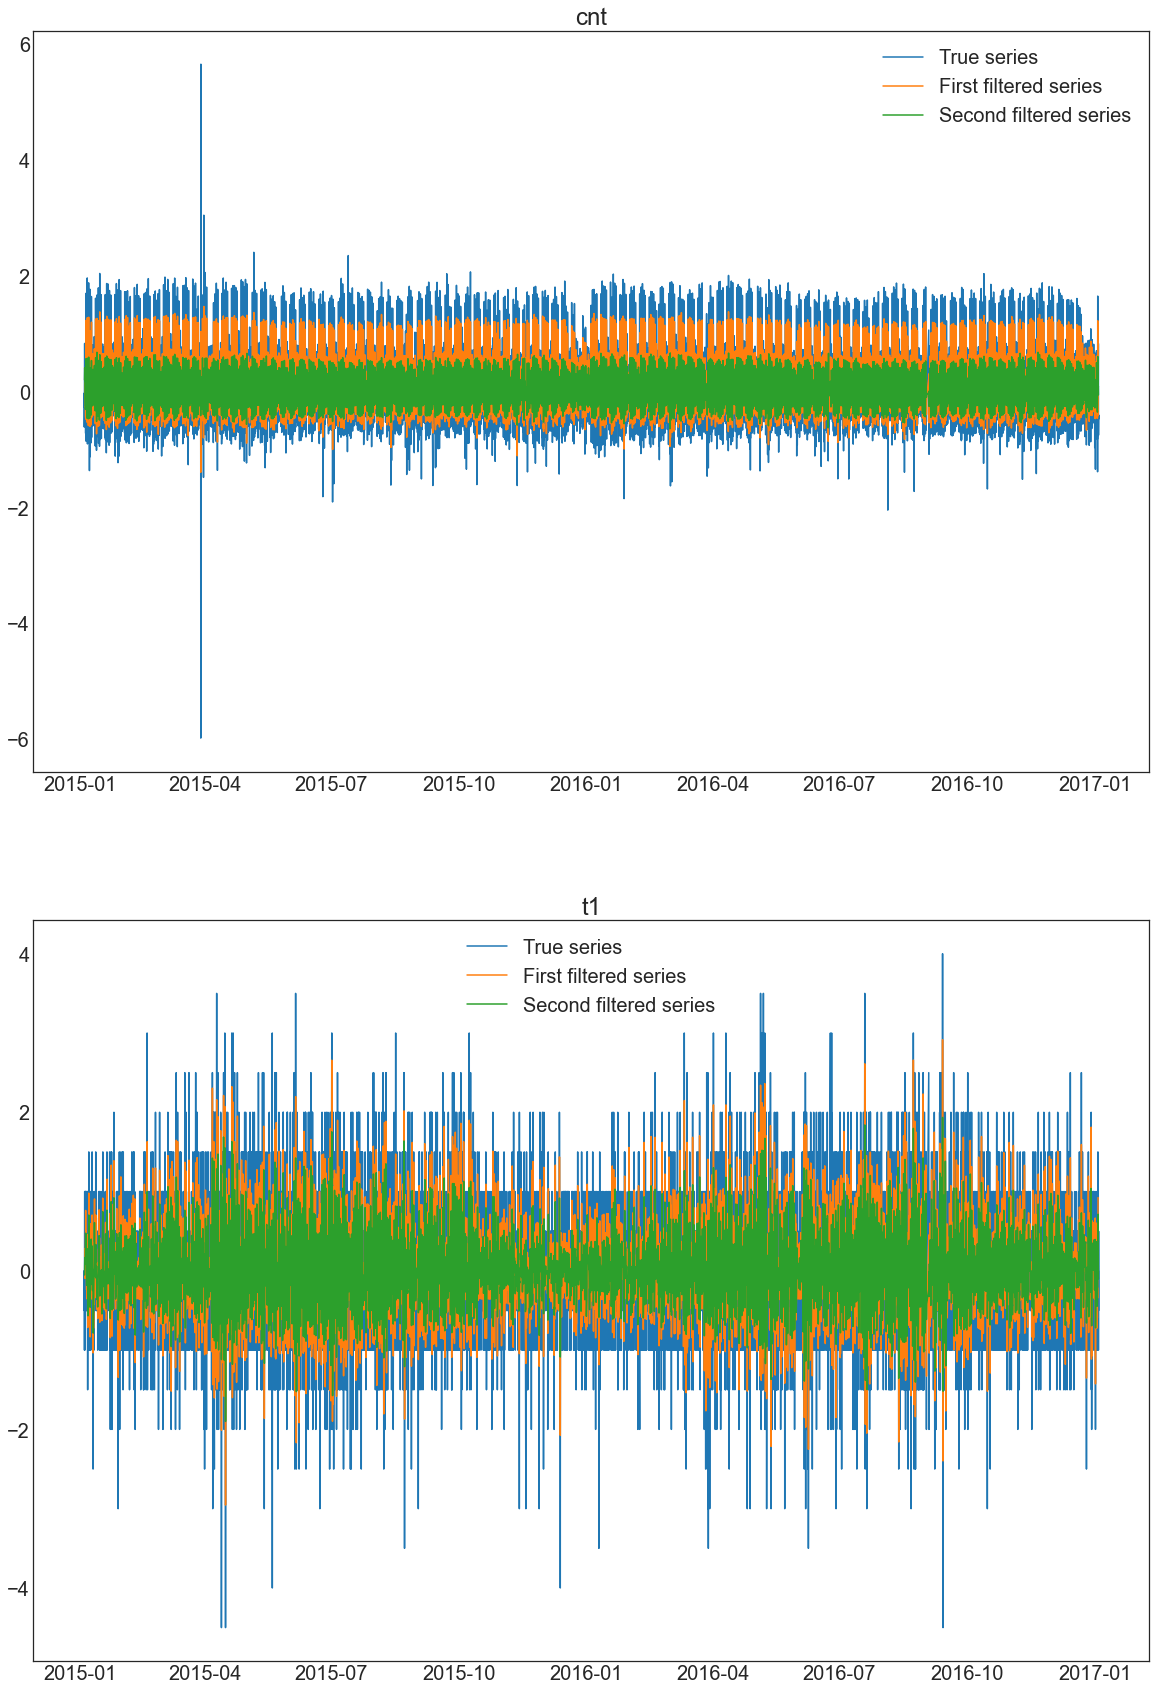

In [235]:
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_target_filtered(targets[i], ax=ax)

In [245]:
def plot_sdf(series, ax):
    f, pxx = signal.welch(series, nfft=1000, nperseg=100, scaling='spectrum')
    f_filt1, pxx_filt1 = signal.welch(filter1(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    f_filt2, pxx_filt2 = signal.welch(filter2(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    ax.plot(f, pxx, linewidth=3, label='True series')
    ax.plot(f_filt1, pxx_filt1, label='First filtered series')
    ax.plot(f_filt2, pxx_filt2, label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

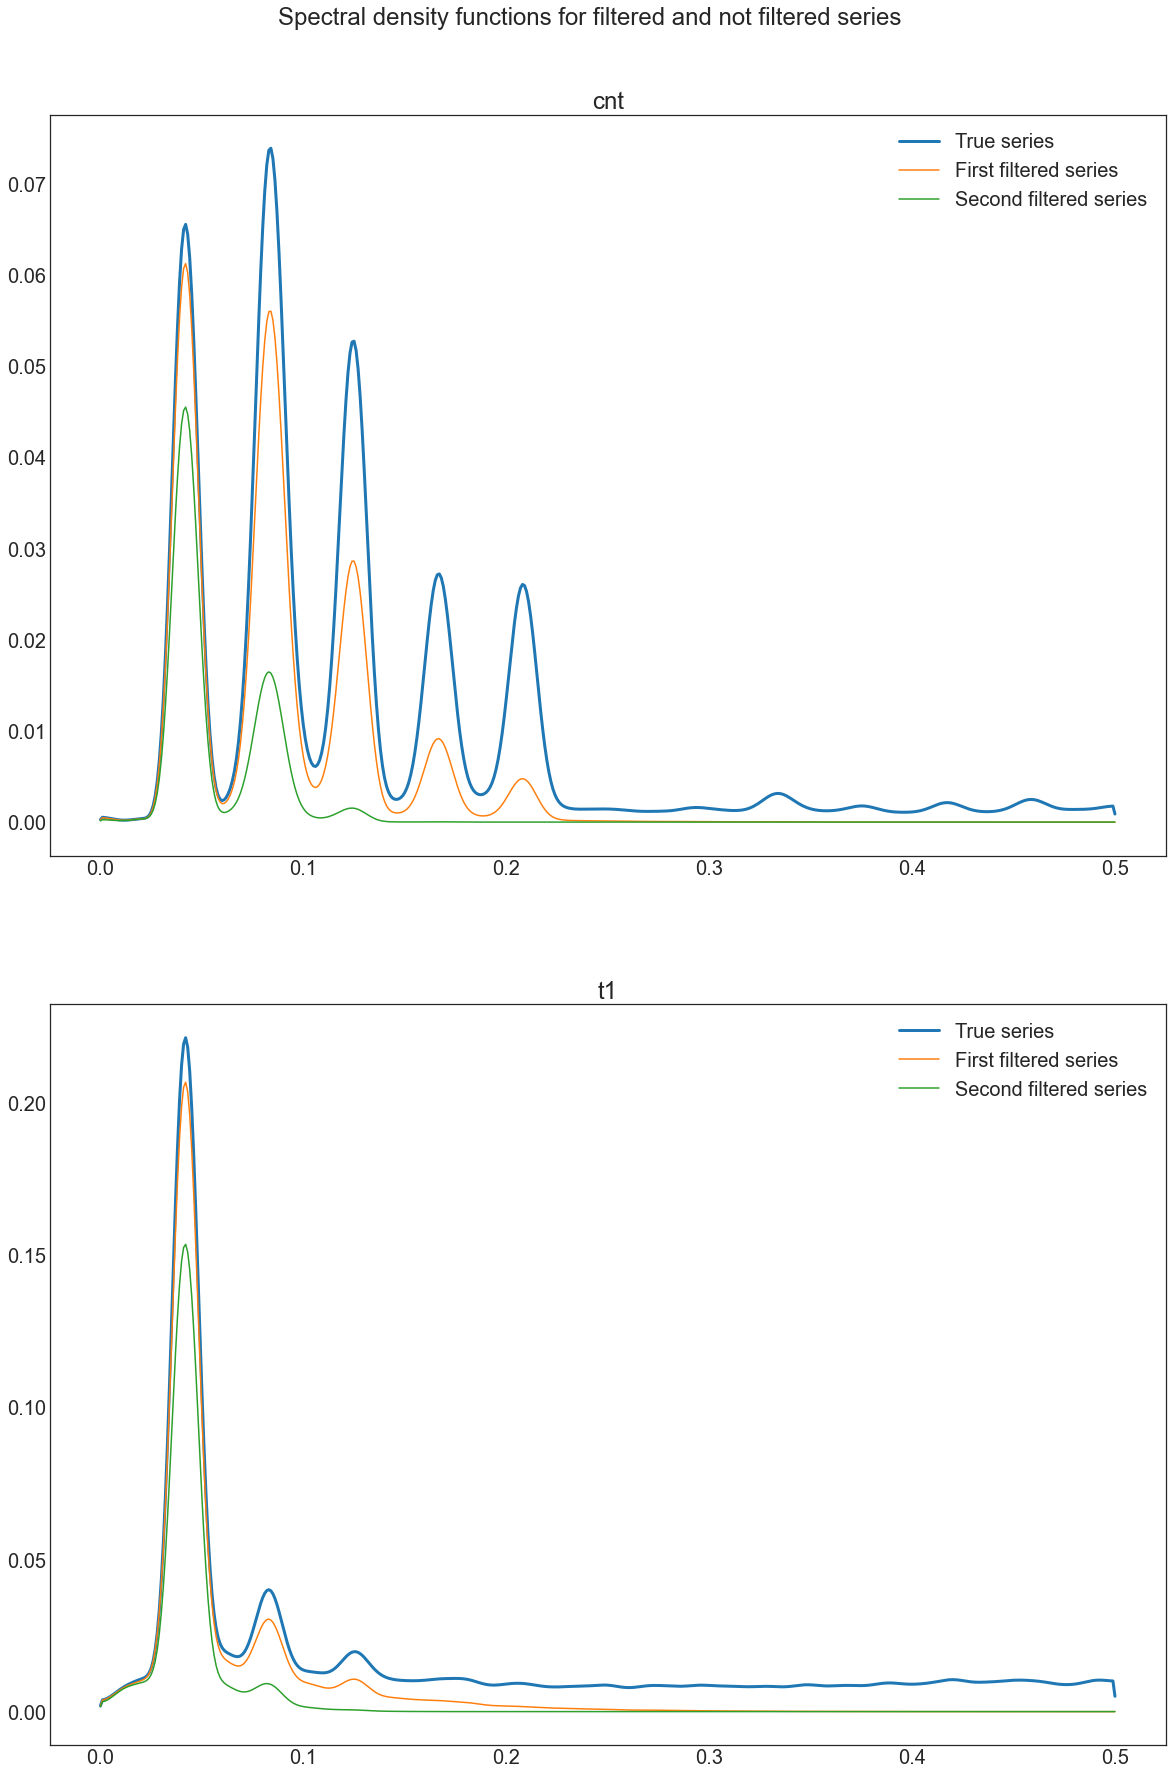

In [246]:
# Estimating spectral density function for with and without filtering
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
plt.suptitle("Spectral density functions for filtered and not filtered series", y=0.93)
for i, ax in enumerate(axes.flatten()):
    plot_sdf(targets[i], ax=ax)

In [ ]:
series = targets[0].diff(24).diff(1).dropna().copy()
p = 12
series_train, series_test = train_test_split(series, test_size=0.9, shuffle=False, random_state=42)
arima = smt.ARIMA(series_train, order=(p, 0, 0)).fit()
shapiro(arima.resid)

In [ ]:
plot_pacf(targets[0].diff(1).dropna());

In [ ]:
series.plot()

In [ ]:
plt.hist(arima.resid, bins=100);

ShapiroResult(statistic=0.956790030002594, pvalue=2.7467445046553933e-22)

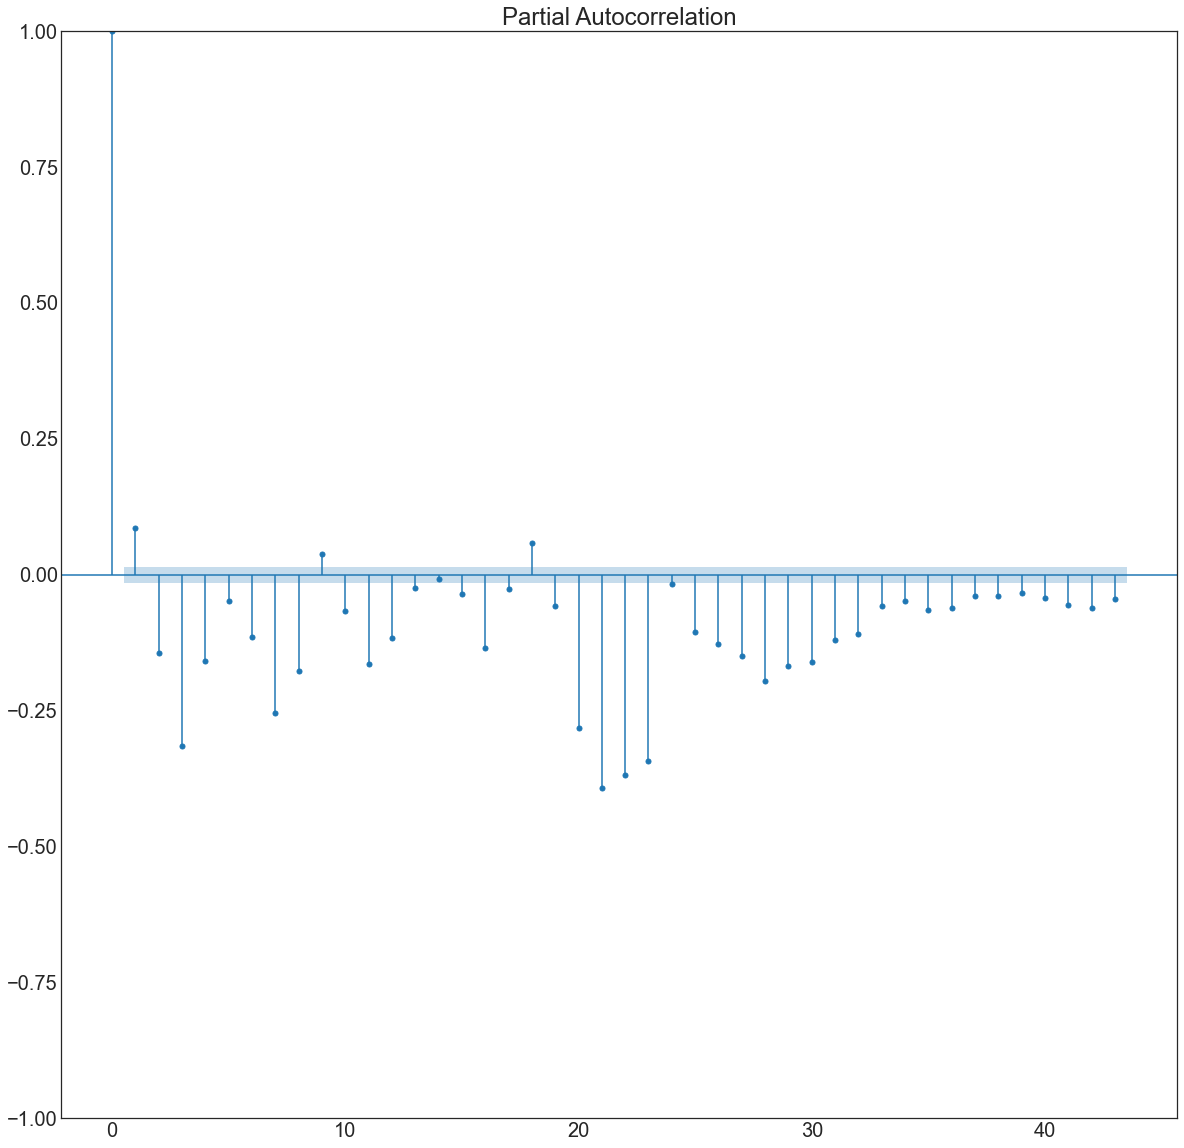

In [299]:
plot_pacf(targets[0].diff(1).dropna());

<AxesSubplot:xlabel='timestamp'>

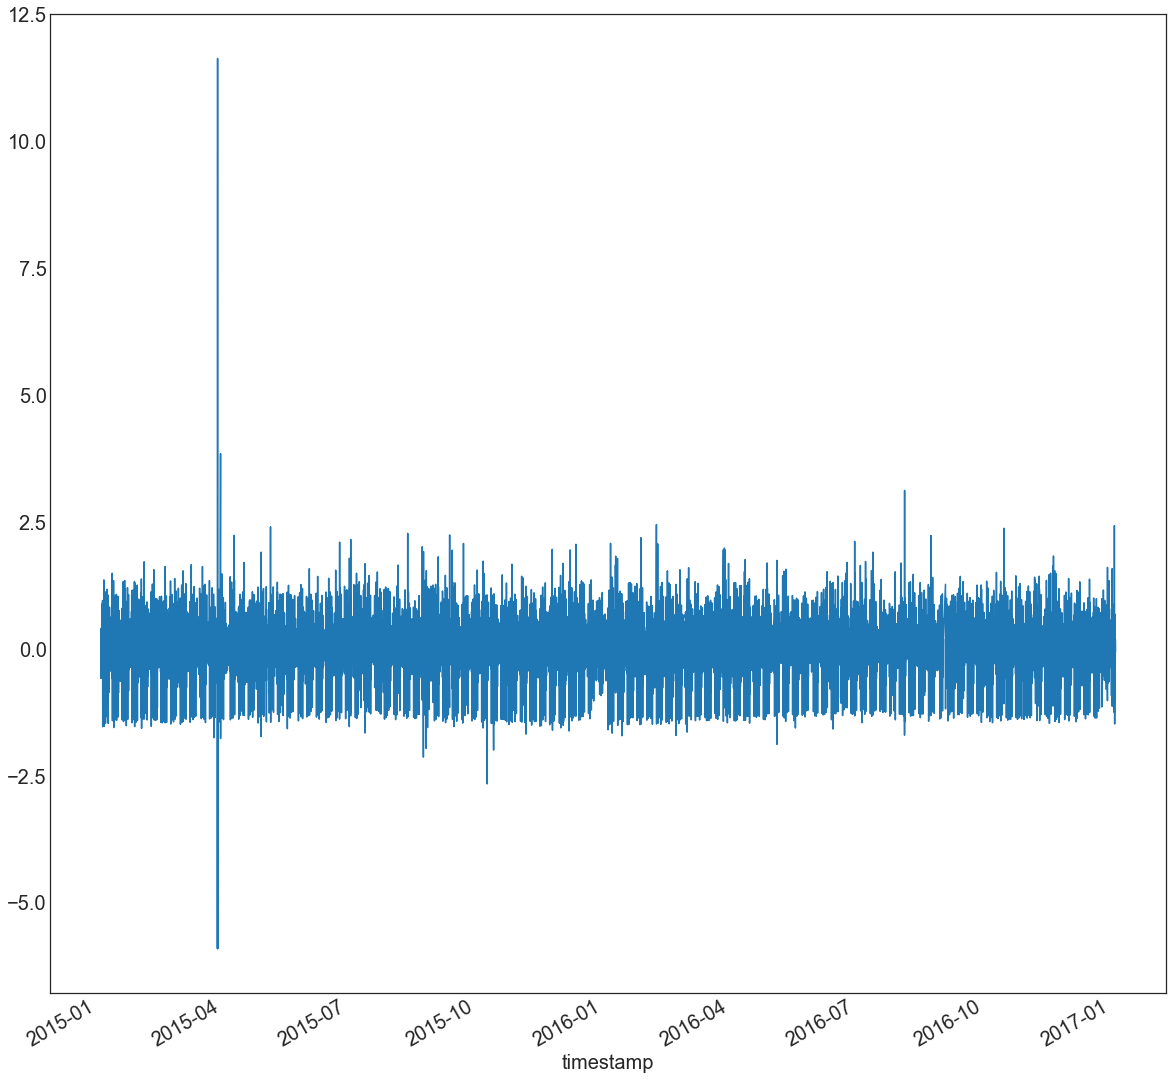

In [300]:
series.plot()

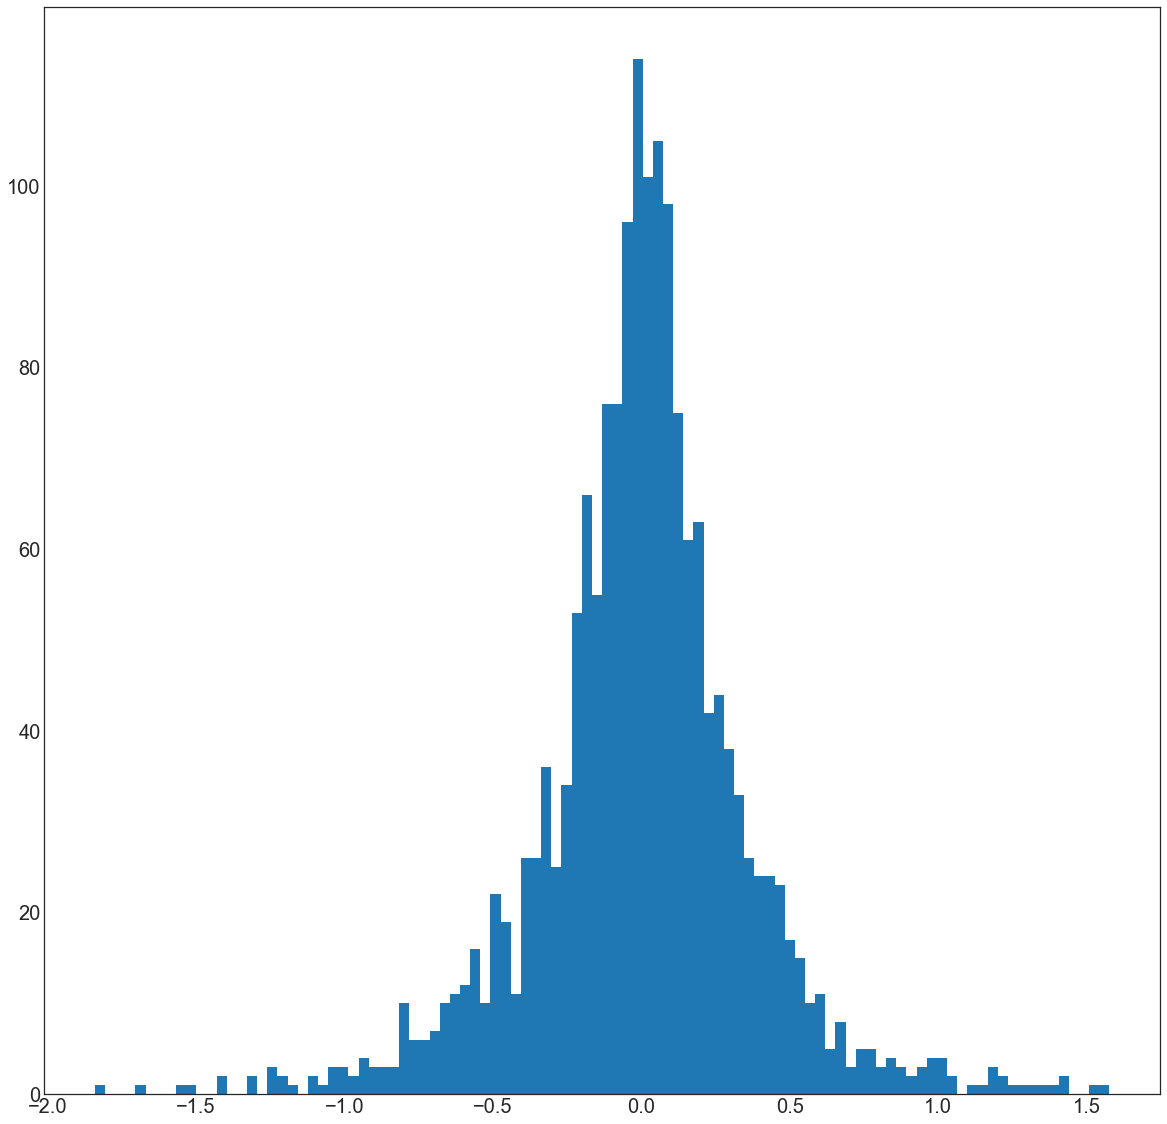

In [306]:
plt.hist(arima.resid, bins=100);